In [2]:
import numpy.linalg as nla
import scipy.linalg as sla
import numpy as np
from numpy import identity as id
from pylab import *
import cmath as cm
import random
import matplotlib.pyplot as plt
import cmath
from itertools import compress, product
import math

In [3]:
def Factorial(N):
    if N==0:
        return 1
    else:
        return N*Factorial(N-1)

def Herm(A):
    A = np.transpose(np.conj(A))
    return A

def GeneralCount(iMin, iMax, L, N):
    IVec = [iMin]*L
    States= []
    Condition = False
    while Condition == False:
        if sum(IVec) == N: States.append(IVec[ : ])
        for k in range(L-1, -2, -1):
            if k ==-1: Condition = True
            if IVec[k] == iMax:
                IVec[k] = iMin
            else:
                IVec[k] += 1
                break
    return States
def Length(N,M):
    i = 0
    Sum = 0
    while i < N+1:
        Sum = Sum + len(GeneralCount(0,i,M/2,i))
        i+=1
    Sum=int(Sum)
    return Sum

def NKron(*args):
  """Calculate a Kronecker product over a variable number of inputs"""
  result = np.array([[1.0]])
  for op in args:  
    result = np.kron(result, op)
  return result

def MagnetZ(Psi, N):
    MagnetSum=0
    Mag=NKron(PZ,id(2**(N-1)))
    Magnet=np.dot(Herm(Psi),np.dot(Mag,Psi))
    Magnet=MagnetSum+0.5*float(np.real(Magnet))
    return Magnet
    
def MagnetX(Psi, N):
    MagnetSum=0
    Mag=NKron(PX,id(2**(N-1)))
    Magnet=np.dot(Herm(Psi),np.dot(Mag,Psi))
    MagnetSum=MagnetSum+0.5*float(np.real(Magnet))
    return Magnet
def LongCorr(Psi, N):
    Corr=NKron(PX,id(2**(N-2)),PX)
    XN=NKron(id(2**(N-1)),PX)
    Correlation=float(np.real(np.dot(Herm(Psi),np.dot(Corr, Psi)))) - float(np.real(MagnetX(Psi,N))) * float(np.real(np.dot(Herm(Psi), np.dot(XN,Psi))))
    return float(np.real(Correlation))


def CompBasis(N):
    CompBasis=[]
    Basis=(list(product(Spin, repeat=int(N))))
    i=0    
    while i<len(Basis):    
        j=0
        Element=1    
        while j<N:
            Element=(NKron(Element, Basis[i][j]))
            j+=1
        CompBasis.append(Element)
        i+=1
    return CompBasis   

In [4]:
#Spin states in the z-basis
up = np.array([1, 0])
down = np.array([0, 1])
Spin=[up,down]
#Spin matrices
PX = np.array([[0, 1],[ 1, 0]])
PZ = np.array([[1, 0],[0, -1]])
PY = np.array([[0, -1.0*cm.sqrt(-1.0)], [cm.sqrt(-1.0), 0]])

SpinBasis=list(product([0.5,-0.5], repeat=N))
DualBasis = []
NewVec= np.zeros(len(Basis),dtype=np.complex128)
i = 0
while i <len(Basis):
    NewVec[i] = 1
    DualBasis.append(NewVec)
    NewVec=np.zeros(len(Basis),dtype=np.complex128)
    i+=1

In [8]:
R=0
Values=[]
Repeats=1
J=1
StatEntropy=[]
N=int(12)
h=10
U=0.5
Xi=0.5
Time=50
t=0.02
Basis=[]
SpinTot=[]
Ratio=[]

while R<Repeats:
    H=np.zeros((2**N,2**N),dtype=np.complex128)
    H=H+J*(NKron(PX,PX,id(2**(N-2))) + NKron(id(2**(N-2)),PX,PX))
    H=H+J*(NKron(PY,PY,id(2**(N-2))) + NKron(id(2**(N-2)),PY,PY))
    H=H+U*(NKron(PZ,PZ,id(2**(N-2))) + NKron(id(2**(N-2)),PZ,PZ))
    i=1
    while i<N-1:
        H=H+J*(NKron(id(2**i),PX,PX,id(2**(N-2-i))))
        H=H+J*(NKron(id(2**i),PY,PY,id(2**(N-2-i))))
        H=H+U*(NKron(id(2**i),PZ,PZ,id(2**(N-2-i))))
        i+=1
    
    i=0
    while i<N:
        H=H+random.uniform(-h,h)*(NKron(id(2**i),PZ,id(2**(N-i-1))))
        H=H+Xi*(NKron(id(2**i),PX,id(2**(N-i-1))))
        i+=1
        
    EigVals, EigVecs = nla.eigh(H)
    Evolution = np.zeros((2**N,2**N),dtype=np.complex128)    
    
    P = 0    
    while P < len(EigVals):
        Evolution = Evolution + cmath.exp(-t*complex(0,1)*EigVals[P])*(np.outer(np.transpose(EigVecs[:,P]),np.conjugate(EigVecs[:,P])))
        P += 1
    
    i = 0  
    Psi=1
    while i<N:
        r=random.uniform(-np.pi,np.pi)
        Psi=NKron(Psi,(np.cos(r)*up+np.sin(r)*down))
        i += 1
    Psi=np.transpose(Psi)
 
    
    WaveFunction=Psi.reshape(int(2**(N/2)),int(2**(N/2)))   
    EntropyList=[]
    Z,S,V = nla.svd(WaveFunction, full_matrices=True)
    i = 0
    Entropy = 0
    while i<len(S):
        if S[i]==0:
            Entropy=Entropy+0
        else:
            Entropy=Entropy-(pow(S[i],2)*math.log(pow(S[i],2), 2))
        i+=1
    EntropyList.append(Entropy)
    
    
    tau=0.02
    while tau < Time:    
        Psi = np.dot(Evolution,Psi)
        WaveFunction=Psi.reshape(int(2**(N/2)),int(2**(N/2)))   
               
        Z,S,V = nla.svd(WaveFunction, full_matrices=True)
        i = 0
        Entropy = 0
        while i<len(S):
            if S[i]==0:
                Entropy=Entropy+0
            else:
                Entropy=Entropy-(pow(S[i],2)*math.log(pow(S[i],2),2))
            i+=1
        EntropyList.append(Entropy)
    

        
        tau+=t
    StatEntropy.append(EntropyList)

    R+=1
    print("Not today, Satan!")


Not today, Satan!


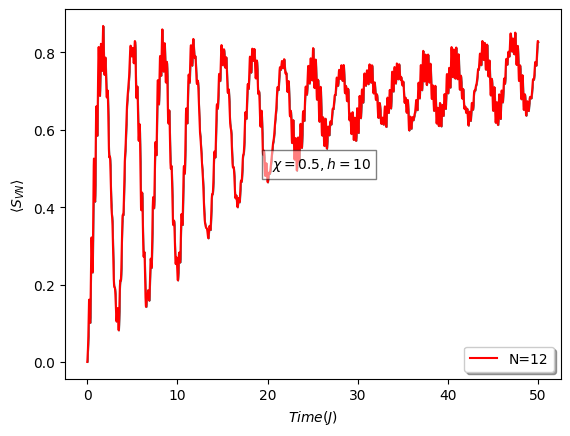

In [9]:
ymin=[]
ymax=[]       
       
Entropy=[]
Error=[]
StatEntropy=np.transpose(StatEntropy)
i=0
while i<int(Time/t):   
    Ent=np.average(StatEntropy[i])
    Err=np.std(StatEntropy[i])/np.sqrt(R)
    Entropy.append(Ent)
    Error.append(Err)
    ymin.append(Ent-Err)
    ymax.append(Ent+Err)
    i+=1
    
    
x=np.linspace(0,50,num=2500)
plt.plot(x,Entropy, 'r', label='N=%s'%(N))
plt.fill_between(x, ymin, ymax, color='gray')
plt.xlabel(r'$ Time (J)$')
plt.ylabel(r'$ \langle S_{VN}\rangle$ ')
plt.legend(loc='lower right', shadow = True)
plt.text(20, 0.5, r' $ \chi=%s, h=%s$' %(Xi,h),  bbox=dict(facecolor='white', alpha=0.5))
plt.show()